In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

%matplotlib inline

## Load results

In [38]:
all_out = glob("out/**/*.pkl")

In [39]:
all_out = [load_pickle(p) for p in all_out]

In [40]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [41]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [42]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(["mean", "std", sem])

In [43]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [44]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [45]:
grouped_res.loc[2, :]

frac_valid                      accuracy            \
                                mean       std       sem      mean       std   
representation train_size                                                      
inchi          10              1.000  0.000000  0.000000  0.509600  0.075504   
               50              1.000  0.000000  0.000000  0.574400  0.025550   
               100             1.000  0.000000  0.000000  0.570400  0.038011   
               200             1.000  0.000000  0.000000  0.616000  0.045255   
               500             1.000  0.000000  0.000000  0.644000  0.022271   
iupac_name     10              1.000  0.000000  0.000000  0.515200  0.024232   
               50              1.000  0.000000  0.000000  0.563200  0.026442   
               100             1.000  0.000000  0.000000  0.550400  0.030672   
               200             1.000  0.000000  0.000000  0.614000  0.014142   
               500             1.000  0.000000  0.000000  0.676000  0.030199   
selfies        10              0.996  0.004899  0.002191  0.538953  0.026659   
               50              1.000  0.000000  0.000000  0.552000  0.018547   
               100             1.000  0.000000  0.000000  0.556000  0.061188   
               200             1.000  0.000000  0.000000  0.594000  0.031113   
               500             1.000  0.000000  0.000000  0.648000  0.010583   
smiles         10              1.000  0.000000  0.000000  0.511333  0.053631   
               50              1.000  0.000000  0.000000  0.570400  0.057730   
               100             1.000  0.000000  0.000000  0.599200  0.046251   
               200             1.000  0.000000  0.000000  0.617333  0.052205   
               500             1.000  0.000000  0.000000  0.678667  0.036295   

                                     f1_macro                      f1_micro  \
                                sem      mean       std       sem      mean   
representation train_size                                                     
inchi          10          0.033766  0.507428  0.076043  0.034007  0.509600   
               50          0.011426  0.573998  0.025435  0.011375  0.574400   
               100         0.016999  0.566815  0.035285  0.015780  0.570400   
               200         0.032000  0.608373  0.044268  0.031302  0.616000   
               500         0.012858  0.643194  0.022063  0.012738  0.644000   
iupac_name     10          0.010837  0.448631  0.079292  0.035460  0.515200   
               50          0.011825  0.561892  0.026464  0.011835  0.563200   
               100         0.013717  0.549739  0.030767  0.013760  0.550400   
               200         0.010000  0.612223  0.011709  0.008280  0.614000   
               500         0.017436  0.675774  0.029943  0.017287  0.676000   
selfies        10          0.011922  0.482657  0.066872  0.029906  0.538953   
               50          0.008295  0.544742  0.026564  0.011880  0.552000   
               100         0.027364  0.544762  0.071155  0.031822  0.556000   
               200         0.022000  0.593722  0.031505  0.022278  0.594000   
               500         0.006110  0.646837  0.009708  0.005605  0.648000   
smiles         10          0.021895  0.496925  0.049908  0.020375  0.511333   
               50          0.025818  0.567530  0.059384  0.026557  0.570400   
               100         0.020684  0.597616  0.046495  0.020793  0.599200   
               200         0.030140  0.615638  0.052925  0.030556  0.617333   
               500         0.020955  0.677772  0.037246  0.021504  0.678667   

                                                  kappa                      
                                std       sem      mean       std       sem  
representation train_size                                                    
inchi          10          0.075504  0.033766  0.018654  0.150985  0.067523  
               50          0.025550  0.011426  0.149092

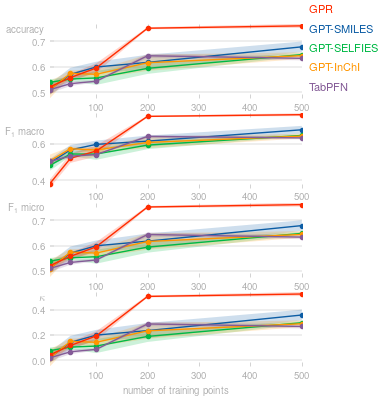

In [46]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[2, "smiles", :].index,
            grouped_res.loc[2, "smiles", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "smiles", :].index,
            grouped_res.loc[2, "smiles", :][metric]["mean"]
            - grouped_res.loc[2, "smiles", :][metric]["sem"],
            grouped_res.loc[2, "smiles", :][metric]["mean"]
            + grouped_res.loc[2, "smiles", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "selfies", :].index,
            grouped_res.loc[2, "selfies", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "selfies", :].index,
            grouped_res.loc[2, "selfies", :][metric]["mean"]
            - grouped_res.loc[2, "selfies", :][metric]["sem"],
            grouped_res.loc[2, "selfies", :][metric]["mean"]
            + grouped_res.loc[2, "selfies", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "inchi", :].index,
            grouped_res.loc[2, "inchi", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "inchi", :].index,
            grouped_res.loc[2, "inchi", :][metric]["mean"]
            - grouped_res.loc[2, "inchi", :][metric]["sem"],
            grouped_res.loc[2, "inchi", :][metric]["mean"]
            + grouped_res.loc[2, "inchi", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            - grouped_xgboost_res.loc[2, :][metric]["sem"],
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            + grouped_xgboost_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            - grouped_tabpfn_res.loc[2, :][metric]["sem"],
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            + grouped_tabpfn_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)

    fig.savefig("lipophilicity-classification_results_binary.pdf", bbox_inches="tight")

In [56]:
find_learning_curve_intersection(
    grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

1.96451533369614

In [57]:
find_learning_curve_intersection(
    grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

1.0171224701420218

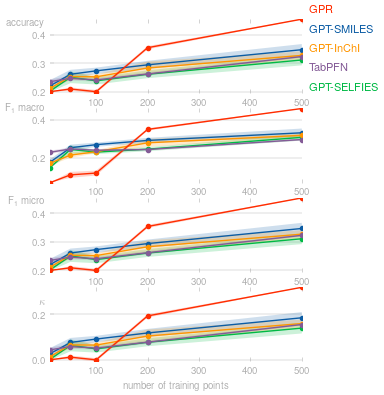

In [47]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, "smiles", :].index,
            grouped_res.loc[5, "smiles", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "smiles", :].index,
            grouped_res.loc[5, "smiles", :][metric]["mean"]
            - grouped_res.loc[5, "smiles", :][metric]["sem"],
            grouped_res.loc[5, "smiles", :][metric]["mean"]
            + grouped_res.loc[5, "smiles", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "selfies", :].index,
            grouped_res.loc[5, "selfies", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "selfies", :].index,
            grouped_res.loc[5, "selfies", :][metric]["mean"]
            - grouped_res.loc[5, "selfies", :][metric]["sem"],
            grouped_res.loc[5, "selfies", :][metric]["mean"]
            + grouped_res.loc[5, "selfies", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "inchi", :].index,
            grouped_res.loc[5, "inchi", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "inchi", :].index,
            grouped_res.loc[5, "inchi", :][metric]["mean"]
            - grouped_res.loc[5, "inchi", :][metric]["sem"],
            grouped_res.loc[5, "inchi", :][metric]["mean"]
            + grouped_res.loc[5, "inchi", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)

    fig.savefig("lipophilicity-classification_results_5_class.pdf", bbox_inches="tight")